In [1]:
import numpy as np
np.set_printoptions(precision=2)

# all temps in centigrade
brownie_target = 85
room_temp = 18.333
side_length = 40
pan_temp = room_temp
oven_temp = 162.778

h = 9.14
A = 0.0001 # 0.01m ^2

brownie_density = 500
brownie_specific_heat = 2550
brownie_conductivity = 0.15
brownie_alpha = brownie_conductivity / (brownie_density * brownie_specific_heat)

steel_density = 7832
steel_specific_heat = 434
steel_conductivity = 59
steel_alpha = steel_conductivity / (steel_density * steel_specific_heat)

print(brownie_alpha)
print(steel_alpha)
print(A)

def initialize_brownie_pan(side_length, room_temp):
    return np.full((side_length, side_length), room_temp)


1.176470588235294e-07
1.7357597096632978e-05
0.0001


In [2]:
def heat_transfer_over_increment(brownie_pan: np.array, pan_temp, dx, dt):
    # heat transfer from oven to pan
    d_pan_temp = h * A * (oven_temp - pan_temp)
    pan_temp += dt * d_pan_temp 

    # heat transfer from pan to brownie
    time_derivative = np.zeros(brownie_pan.shape)
    for x in range(side_length):
        for y in range(side_length):
            # edge
            if (x == 0 and y == 0): # top left corner
                outside_squares = 2 * pan_temp 
                surrounding_squares = brownie_pan[x][y+1] + brownie_pan[x+1][y] + outside_squares
                curr_square = 4 * brownie_pan[x][y]
            elif (x == 0 and y == (side_length - 1)): # bottom left corner
                outside_squares = 2 * pan_temp 
                surrounding_squares = brownie_pan[x][y-1] + brownie_pan[x+1][y] + outside_squares
                curr_square = 4 * brownie_pan[x][y]
            elif (x == (side_length - 1) and y == 0): # top right corner
                outside_squares = 2 * pan_temp 
                surrounding_squares = brownie_pan[x][y+1] + brownie_pan[x-1][y] + outside_squares
                curr_square = 4 * brownie_pan[x][y]
            elif (x == (side_length - 1) and y == (side_length - 1)): # bottom right corner
                outside_squares = 2 * pan_temp 
                surrounding_squares = brownie_pan[x][y-1] + brownie_pan[x-1][y] + outside_squares
                curr_square = 4 * brownie_pan[x][y]
            elif x == 0: # left edge
                surrounding_squares = brownie_pan[x][y+1] + brownie_pan[x][y-1] + brownie_pan[x+1][y] + pan_temp
                curr_square = 4 * brownie_pan[x][y]
            elif y == 0: # top edge
                surrounding_squares = brownie_pan[x+1][y] + brownie_pan[x-1][y] + brownie_pan[x][y+1] + pan_temp
                curr_square = 4 * brownie_pan[x][y]
            elif x == (side_length - 1): # right edge
                surrounding_squares = brownie_pan[x][y+1] + brownie_pan[x][y-1] + brownie_pan[x-1][y] + pan_temp
                curr_square = 4 * brownie_pan[x][y]
            elif y == (side_length - 1): # bottom edge
                surrounding_squares = brownie_pan[x+1][y] + brownie_pan[x-1][y] + brownie_pan[x][y-1] + pan_temp
                curr_square = 4 * brownie_pan[x][y]
            else:
                surrounding_squares = brownie_pan[x + 1][y] + brownie_pan[x - 1][y] + brownie_pan[x][y + 1] + brownie_pan[x][y - 1]
                curr_square = 4 * brownie_pan[x][y]

            time_derivative[x][y] = (brownie_alpha / (dx ** 2)) * (surrounding_squares - curr_square)

    brownie_pan += (time_derivative * dt)
    return brownie_pan, pan_temp



In [3]:
brownie_pan = initialize_brownie_pan(side_length, room_temp)
counter = 0
while True:
    brownie_pan, pan_temp = heat_transfer_over_increment(brownie_pan, pan_temp, dx=0.005, dt=0.01) # 0.01 meters (1cm), 0.01 seconds
    # if counter % 10000 == 0:
    #     print(brownie_pan)
    counter += 1
    if brownie_pan[int(side_length/2)][int(side_length/2)] >= brownie_target:
        print(f"{counter / 100 / 60} minutes of cooking")
        print(pan_temp)
        break

print(brownie_pan)

5.965333333333334 minutes of cooking
58.63567874650475
[[73.4  77.09 77.9  ... 77.9  77.09 73.4 ]
 [77.09 82.12 83.25 ... 83.25 82.12 77.09]
 [77.9  83.25 84.48 ... 84.48 83.25 77.9 ]
 ...
 [77.9  83.25 84.48 ... 84.48 83.25 77.9 ]
 [77.09 82.12 83.25 ... 83.25 82.12 77.09]
 [73.4  77.09 77.9  ... 77.9  77.09 73.4 ]]


In [6]:
cooked_baseline = np.full((side_length, side_length), brownie_target + 3)

over_cooked = brownie_pan - cooked_baseline
over_cooked = over_cooked.clip(min=0)

avg_error = np.sum(over_cooked) / (side_length ** 2)

print(avg_error)

0.0


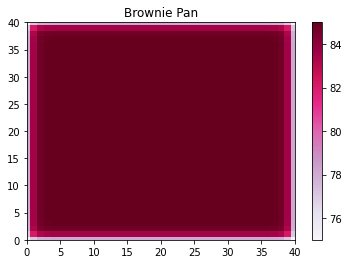

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# generate 2 2d grids for the x & y bounds
y, x = np.meshgrid(np.linspace(0, side_length, side_length), np.linspace(0, side_length, side_length))

# z = (1 - x / 2. + x ** 5 + y ** 3) * np.exp(-x ** 2 - y ** 2)
# # x and y are bounds, so z should be the value *inside* those bounds.
# # Therefore, remove the last value from the z array.
# z = z[:-1, :-1]
z = brownie_pan
z_min, z_max = 75, np.abs(z).max()

fig, ax = plt.subplots()

c = ax.pcolormesh(x, y, z, cmap='PuRd', vmin=z_min, vmax=z_max, shading='auto')
ax.set_title('Brownie Pan')
# set the limits of the plot to the limits of the data
ax.axis([x.min(), x.max(), y.min(), y.max()])
fig.colorbar(c, ax=ax)

plt.show()